# [Dev notebook]
## How does STGL work with TICC data?

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.cluster.hierarchical import AgglomerativeClustering
from scipy import linalg
from sklearn.metrics import v_measure_score
from sklearn.model_selection import StratifiedShuffleSplit

from regain.utils import structure_error, error_norm_time, normalize_matrix

In [104]:
from imp import reload
from regain.covariance import kernel_time_graphical_lasso_, kernel_latent_time_graphical_lasso_
reload(kernel_time_graphical_lasso_)
reload(kernel_latent_time_graphical_lasso_)
from regain.datasets import kernels; reload(kernels);

In [105]:
# n_dim = 10
# w_size = 1
# n_samples = 50
# clusters=(0,0,0,0,1,1,1,1,0,0,0,0)

# data = kernels.make_ticc_dataset_v3(
#     clusters=clusters,
#     w_size=w_size, n_dim=n_dim, n_samples=n_samples)
# X, y = data.X, data.y

# # print the inv matrix
# res = sns.clustermap(data.inv, row_cluster=False, col_cluster=False)
# ax = res.ax_heatmap
# for i in range(n_samples * len(clusters)):
#     ax.axvline((i + 1) * n_dim)
#     ax.axhline((i + 1) * n_dim)

# cov = []
# for c in np.unique(y):
#     idx = y == c
#     cov.append(empirical_covariance(X[idx]))
# cov = np.asarray(cov)

# kernel = np.zeros((cov.shape[0], cov.shape[0]))
# for i in range(cov.shape[0]):
#     for j in range(i + 1, cov.shape[0]):
#         kernel[i, j] = kernel[j, i] = (np.linalg.norm((cov[i]) - (cov[j])))

# mm = np.sum(np.abs(kernel), axis=1)
# kernel += np.eye(cov.shape[0]) * mm

# normalize_matrix(kernel)

# from sklearn.gaussian_process import kernels as skkernels
# rbf = kernels.RBF

# mdl = kernel_time_graphical_lasso_.KernelTimeGraphicalLasso(psi='l1', max_iter=500, alpha=0.1, beta=1, kernel=rbf).fit(X, y)

# from regain.norm import l1_od_norm
# mdl.similarity_matrix = kernel_time_graphical_lasso_.precision_similarity(mdl.precision_, l1_od_norm)

In [106]:
from time import time

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from regain.covariance import time_graphical_lasso_, latent_time_graphical_lasso_

from ticc import TICC_solver; 
from imp import reload; reload(TICC_solver)

<module 'ticc.TICC_solver' from '/home/federicot/src/fdtomasi/TICC/ticc/TICC_solver.py'>

In [107]:
# ticc = TICC_solver.TICC(number_of_clusters=np.unique(clusters).size, window_size=1)
# cluster_assignment, cluster_MRFs = ticc.fit(X)

# from sklearn.metrics import v_measure_score
# v_measure_score(data.id_cluster, cluster_assignment)

# pipe_stgl = Pipeline([('stgl', clone(stgl)), ('clust', clone(clust))])
# labels_pred = pipe_stgl.set_params(clust__n_clusters=np.unique(clusters).size).fit_predict(X, y)

# v_measure_score(data.id_cluster, np.repeat(labels_pred, n_samples))

In [108]:
# n_clusts = np.random.randint(10) + 2
# clusters = np.random.choice(list(range(n_clusts)), size=15)
# data = kernels.make_ticc_dataset_v3(
#     clusters=clusters,
#     w_size=w_size, n_dim=n_dim, n_samples=20)
# X, y = data.X, data.y

In [109]:
alpha = 2
beta = 3

In [110]:
stgl = kernel_time_graphical_lasso_.SimilarityTimeGraphicalLasso(alpha=alpha, beta=beta, max_iter=500, psi='l1')
sltgl = kernel_latent_time_graphical_lasso_.SimilarityLatentTimeGraphicalLasso(
    alpha=alpha, tau=5, beta=beta, eta=0.75, max_iter=500, psi='l1')
clust = AgglomerativeClustering(affinity='precomputed', linkage='complete')

In [111]:
# from sklearn.model_selection import StratifiedShuffleSplit
# from skopt import searchcv; from imp import reload; reload(searchcv)
# from skopt.space import Real, Categorical, Integer
# from sklearn.datasets import load_iris
# from sklearn.svm import SVC 
# from sklearn.model_selection import train_test_split

# domain = {'alpha': Real(1e-1, 1e0, prior='log-uniform'),
#           'tau': Real(1e-1, 1e+1, prior='log-uniform'),
#           'beta': Integer(1, 60)}
    
# cv = StratifiedShuffleSplit(10, test_size=0.2)
    
# bscv = searchcv.BayesSearchCV(sltgl, domain, n_iter=32, cv=cv)

# bscv.fit(X, y)

In [112]:
def set_results(vs, model, name, i, labels_true, labels_pred, thetas_true_sparse, thetas_true_rep,
                obs_precs_sparse, obs_precs, tac):
    vs.setdefault((name, i), {}).setdefault('model', []).append(model)
    vs.setdefault((name, i), {}).setdefault('v_measure', []).append(
        v_measure_score(labels_true, labels_pred))
    vs.setdefault((name, i), {}).setdefault('structure_error', []).append(
        structure_error(thetas_true_sparse, obs_precs_sparse, no_diagonal=True))
    vs.setdefault((name, i), {}).setdefault('error_norm', []).append(
        error_norm_time(thetas_true_rep, obs_precs))
    vs.setdefault((name, i), {}).setdefault('error_norm_sparse', []).append(
        error_norm_time(thetas_true_sparse, obs_precs_sparse))
    vs.setdefault((name, i), {}).setdefault('time', []).append(tac)

In [113]:
from sklearn.covariance import EmpiricalCovariance, GraphicalLasso

In [173]:
from sklearn.gaussian_process.kernels import ExpSineSquared
from regain.bayesian import wishart_process_, sampling, stats; reload(sampling);reload(stats);
reload(wishart_process_);

In [ ]:
reload(kernels)
partitions = [5, 10, 50, 100, 500, 1000]
# partitions = [50, 100, 200]
n_splits = 10

n_dim = 10
w_size = 1
n_samples = 1000

vs, ne, se = {}, {}, {}
datas = {}
for i in partitions:
    # v_scores, norm_errors, structure_errors = [], [], []
    
    # for train, _, in StratifiedShuffleSplit(n_splits=n_splits, train_size=float(i)).split(X, y):
    for j in range(n_splits):
        n_clusts = np.random.randint(2) + 2
#         print(n_clusts)
        clusters = np.random.choice(list(range(n_clusts)), size=15)
        data = kernels.make_ticc_dataset_v3(
            clusters=clusters,
            w_size=w_size, n_dim=n_dim, n_samples=i)
#         data = kernels.make_cluster_representative(
#             n_clusters=n_clusts, n_dim=n_dim, n_samples=i, shuffle=True)
        X, y = data.X, data.y
        
        n_times = np.unique(y).size
        thetas_true = np.array([data.precs[l] for l in y])
        thetas_true_sparse = np.array([data.sparse_precs[l] for l in y])
        labels_true = data.id_cluster #[::(len(clusters) * i // n_times)]
        
        thetas_true_sparse_rep = np.array([thetas_true_sparse[l] for l in y])
        thetas_true_rep = np.array([thetas_true[l] for l in y])
        
        datas.setdefault(i, {}).setdefault('data', []).append(data)
        datas.setdefault(i, {}).setdefault('thetas_true', []).append(thetas_true)
        datas.setdefault(i, {}).setdefault('thetas_true_sparse', []).append(thetas_true_sparse)
        datas.setdefault(i, {}).setdefault('thetas_true_sparse_rep', []).append(thetas_true_sparse_rep)
        datas.setdefault(i, {}).setdefault('thetas_true_rep', []).append(thetas_true_rep)
        datas.setdefault(i, {}).setdefault('labels_true', []).append(labels_true)
        
        # WP + similarity
        wp = wishart_process_.WishartProcess(kernel='ess', verbose=2, learn_ell=False).fit(X, y)
        tic = time()
        wp.fit(X, y)        
        tac = time() - tic
        tgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(wp.precision_, psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(tgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        mdl = wp
        obs_precs = np.array([mdl.precision_[l] for l in y])
        obs_precs_sparse = np.array([mdl.precision_[l] for l in y])
        
        set_results(vs, mdl, 'wp', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # KTGL + similarity
        ktgl = kernel_time_graphical_lasso_.KernelTimeGraphicalLasso(
            alpha=alpha, max_iter=500, psi='l1', kernel=ExpSineSquared, ker_param=15 / n_clusts)
        tic = time()
        ktgl.fit(X, y)        
        psi = kernel_time_graphical_lasso_.check_norm_prox(ktgl.psi)[0]
        tgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(ktgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(tgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        tac = time() - tic
        mdl = ktgl
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, mdl, 'ktgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)

    
        # KLTGL + similarity
        kltgl = kernel_latent_time_graphical_lasso_.KernelLatentTimeGraphicalLasso(
            alpha=alpha, tau=5, max_iter=500, psi='l1',
            kernel_psi=ExpSineSquared, ker_psi_param=15 / n_clusts,
            kernel_phi=ExpSineSquared, ker_phi_param=15 / n_clusts)
        tic = time()
        kltgl.fit(X, y)
        psi = kernel_latent_time_graphical_lasso_.check_norm_prox(kltgl.psi)[0]
        ltgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(kltgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(ltgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        tac = time() - tic
        mdl = kltgl
        
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, mdl, 'kltgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # STGL
        pipe_stgl = Pipeline([('stgl', clone(stgl)), ('clust', clone(clust))])
        pipe_stgl.set_params(stgl__n_clusters=np.unique(clusters).size, clust__n_clusters=np.unique(clusters).size)
        tic = time()
        labels_pred = pipe_stgl.fit_predict(X, y)
        tac = time() - tic
        labels_pred = np.repeat(labels_pred, i)
        
        mdl = pipe_stgl['stgl']
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, pipe_stgl, 'stgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # SLTGL
        pipe_sltgl = Pipeline([('sltgl', clone(sltgl)), ('clust', clone(clust))])
        pipe_sltgl.set_params(sltgl__n_clusters=np.unique(clusters).size, clust__n_clusters=np.unique(clusters).size)
        tic = time()
        labels_pred = pipe_sltgl.fit_predict(X, y)
        tac = time() - tic
        labels_pred = np.repeat(labels_pred, i)
        
        mdl = pipe_sltgl['sltgl']
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, pipe_sltgl, 'sltgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # EmpiricalCovariance + similarity
        ec = EmpiricalCovariance()
        tic = time()
        mdl = [clone(ec).fit(X[y == c]) for c in np.unique(y)]
        tac = time() - tic
        precisions = np.array([m.precision_ for m in mdl])
        psi = kernel_time_graphical_lasso_.check_norm_prox('l1')[0]
        prec_sims = kernel_time_graphical_lasso_.precision_similarity(precisions, psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        obs_precs = np.array([precisions[l] for l in y])
        obs_precs_sparse = np.array([precisions[l] for l in y])
        
        set_results(vs, mdl, 'ecov', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # GraphicalLasso + similarity
        gl = GraphicalLasso(alpha=alpha)
        tic = time()
        mdl = [clone(gl).fit(X[y == c]) for c in np.unique(y)]
        tac = time() - tic
        precisions = np.array([m.precision_ for m in mdl])
        psi = kernel_time_graphical_lasso_.check_norm_prox('l1')[0]
        prec_sims = kernel_time_graphical_lasso_.precision_similarity(precisions, psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        obs_precs = np.array([precisions[l] for l in y])
        obs_precs_sparse = np.array([precisions[l] for l in y])
        
        set_results(vs, mdl, 'gl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
        
        # TGL + similarity
        tgl = time_graphical_lasso_.TimeGraphicalLasso(alpha=alpha, beta=beta, max_iter=500, psi='l1')
        tic = time()
        tgl.fit(X, y)        
        tac = time() - tic
        psi = kernel_time_graphical_lasso_.check_norm_prox(tgl.psi)[0]
        tgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(tgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(tgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        mdl = tgl
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, mdl, 'tgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)

    
        # LTGL + similarity
        ltgl = latent_time_graphical_lasso_.LatentTimeGraphicalLasso(
            alpha=alpha, beta=beta, tau=5, eta=0.75, max_iter=500, psi='l1')
        tic = time()
        ltgl.fit(X, y)
        tac = time() - tic
        psi = kernel_latent_time_graphical_lasso_.check_norm_prox(ltgl.psi)[0]
        ltgl_prec_sims = kernel_time_graphical_lasso_.precision_similarity(ltgl.get_observed_precision(), psi)
        labels_pred = clust.set_params(n_clusters=np.unique(clusters).size).fit_predict(ltgl_prec_sims)
        labels_pred = np.repeat(labels_pred, i)
        mdl = ltgl
        
        obs_precs = np.array([mdl.get_observed_precision()[l] for l in y])
        obs_precs_sparse = np.array([mdl.get_precision()[l] for l in y])
        
        set_results(vs, mdl, 'ltgl', i, labels_true, labels_pred, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)
                
        ticc = TICC_solver.TICC(number_of_clusters=np.unique(clusters).size, window_size=1,
                                lambda_parameter=alpha)
        tic = time()
        try:
            ticc.fit(X)
            
        except Exception as e:
            print("ticc error. %s" % str(e), end=' ')
            ticc.labels_ = np.zeros_like(labels_true)
            ticc.precision_ = {0: np.eye(X.shape[1])}
            
        tac = time() - tic
        
        obs_precs = np.array([ticc.precision_[l] for l in ticc.labels_])
        obs_precs_sparse = obs_precs
        
        set_results(vs, ticc, 'ticc', i, labels_true, ticc.labels_, 
                    thetas_true_sparse, thetas_true_rep, obs_precs_sparse, obs_precs, tac)

/home/federicot/src/fdtomasi/regain/regain/covariance/kernel_time_graphical_lasso_.py:621: UserWarning: theta did not converge.
  warnings.warn("theta did not converge.")


/home/federicot/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/home/federicot/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
from regain import utils
# utils.save_pickle(vs, 'results_representative_3007_shuffled.pkl')
utils.save_pickle(vs, 'results_representative_3007_ticc.pkl')

vss = utils.load_pickle('results_representative_2507.pkl')

In [20]:
vs.update(vss)

In [153]:
neww = {}
for k, v in vs.items():
    new = {}
    for kk, vv in v.items():
        new.update({(kk, i): vvv for i, vvv in enumerate(vv)})
    neww[k] = new

res_df = pd.DataFrame(neww)
res_df.index.name = ('measure', 'iter')

rr = res_df.T.reset_index()
rr = rr.rename(columns={'level_0': 'method', 'level_1': 'samples'})
rr.method = rr.method.str.upper()

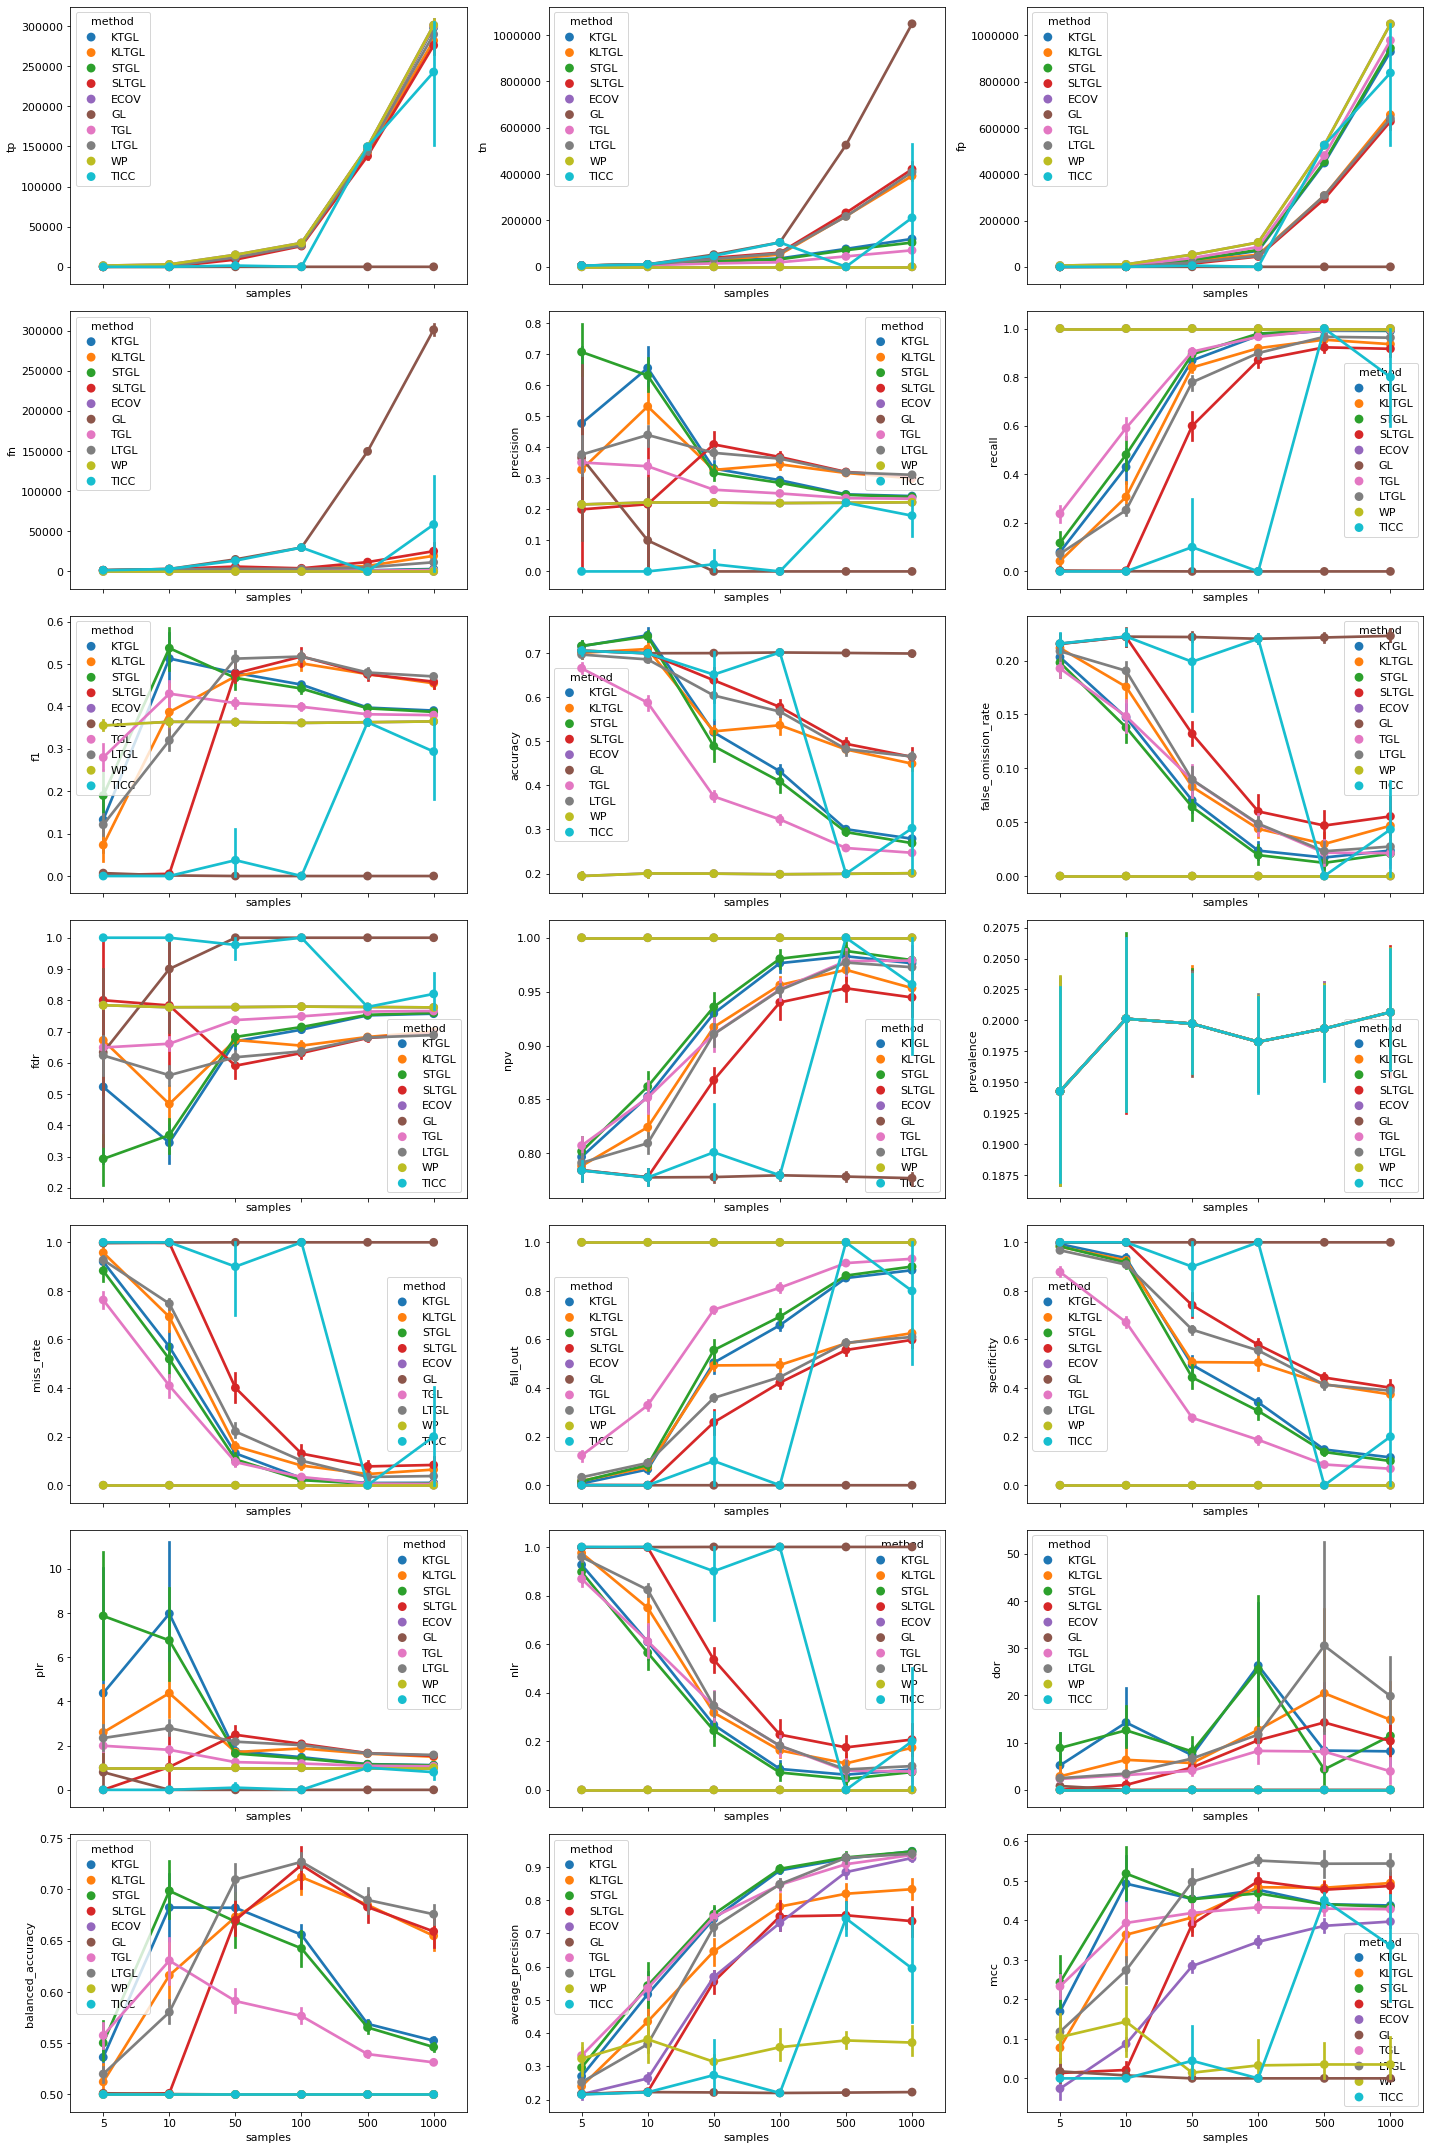

In [154]:
melt = pd.melt(rr, id_vars=['method', 'samples'], value_vars=['structure_error'])
for k in melt.value[0]:
    melt[k] = melt.value.apply(lambda x: x[k])

f, ax = plt.subplots(7,3, figsize=(20,30), sharex=True)
mm = np.array(list(melt.value[0].keys())).reshape(7,3)
for r in range(mm.shape[0]):
    for c in range(mm.shape[1]):
        ax[r,c] = sns.pointplot(x='samples', y=mm[r,c], data=melt, hue='method', ax=ax[r,c])

f.tight_layout()
f

In [14]:
f.savefig('structure_error1.pdf')

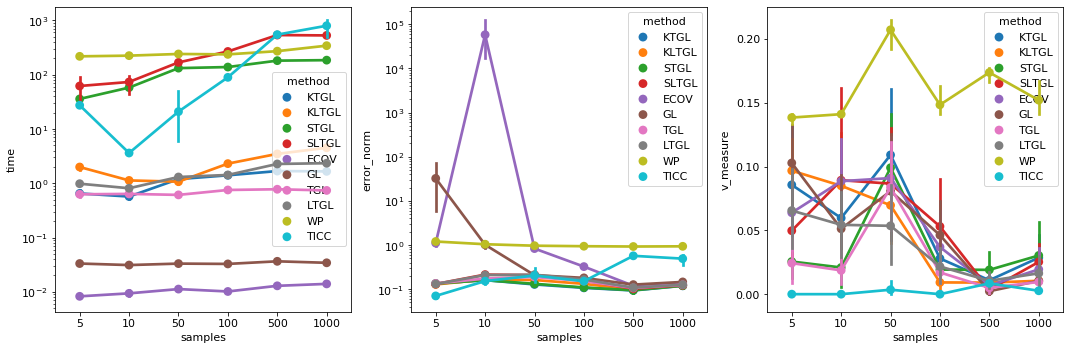

In [155]:
f, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
for i, val in enumerate(['time', 'error_norm', 'v_measure']):
    melt = pd.melt(rr, id_vars=['method', 'samples'], value_vars=[val], value_name=val)
    melt.head()

    ax[i] = sns.pointplot(x='samples', y=val, data=melt, hue='method', ax=ax[i])
    if val in ['time', 'error_norm']:
        ax[i].set_yscale('log')
f.tight_layout()

f

In [16]:
f.savefig('time_error_vscore1.pdf')

makeTICC v3 + STGL, SLTGL, TICC, TGL + similarity, LTGL + similarity

cluster representative + STGL, SLTGL, TICC, TGL + similarity, LTGL + similarity

plot con MCC, vscore, norm error, + 6 plot roc curves coi 10 split e plot_precision_recall

In [86]:
from regain.plotting import results
mdls = ['stgl', 'sltgl', 'tgl', 'ltgl', 'ticc']

In [136]:
mdls = np.unique([x[0] for x in vs])

In [149]:
vs.keys()

dict_keys([('ktgl', 5), ('kltgl', 5), ('stgl', 5), ('sltgl', 5), ('ecov', 5), ('gl', 5), ('tgl', 5), ('ltgl', 5), ('wp', 5), ('ticc', 5), ('ktgl', 10), ('kltgl', 10), ('stgl', 10), ('sltgl', 10), ('ecov', 10), ('gl', 10), ('tgl', 10), ('ltgl', 10), ('wp', 10), ('ticc', 10), ('ktgl', 50), ('kltgl', 50), ('stgl', 50), ('sltgl', 50), ('ecov', 50), ('gl', 50), ('tgl', 50), ('ltgl', 50), ('wp', 50), ('ticc', 50), ('ktgl', 100), ('kltgl', 100), ('stgl', 100), ('sltgl', 100), ('ecov', 100), ('gl', 100), ('tgl', 100), ('ltgl', 100), ('wp', 100), ('ticc', 100), ('ktgl', 500), ('kltgl', 500), ('stgl', 500), ('sltgl', 500), ('ecov', 500), ('gl', 500), ('tgl', 500), ('ltgl', 500), ('wp', 500), ('ticc', 500), ('ktgl', 1000), ('kltgl', 1000), ('stgl', 1000), ('sltgl', 1000), ('ecov', 1000), ('gl', 1000), ('tgl', 1000), ('ltgl', 1000), ('wp', 1000), ('ticc', 1000)])

In [143]:
wp.precision_.shape

(15, 10, 10)

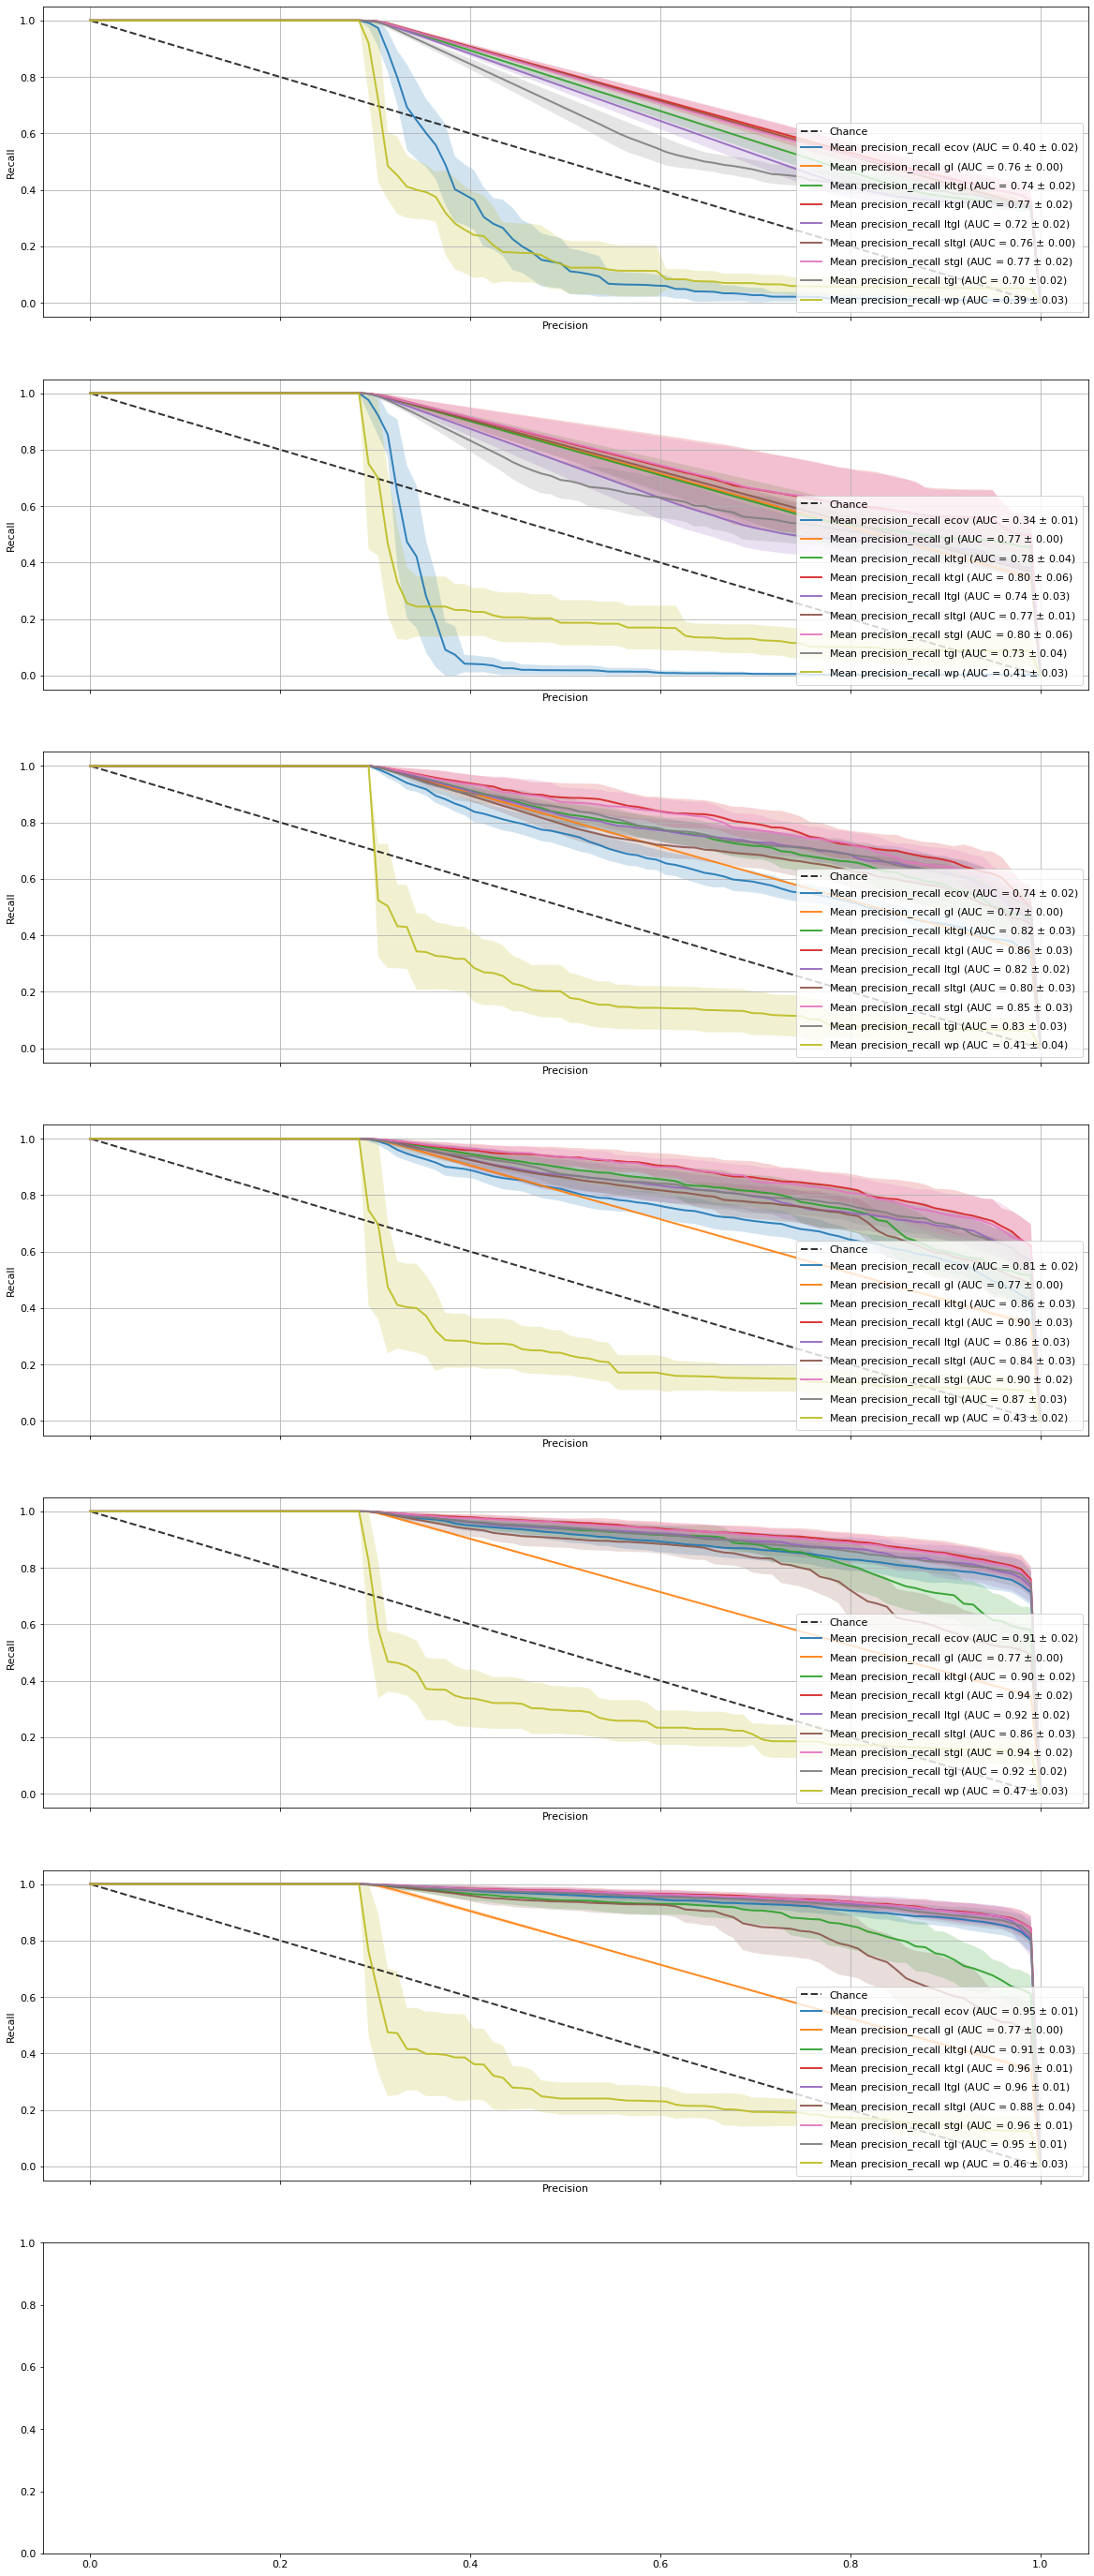

In [150]:
reload(results)
plt.close('all')
f, ax = plt.subplots(7, 1, figsize=(20,50), sharex=True)

pp = {}
for i, n in enumerate(res_df.columns.levels[1]):
    tt = ([np.abs(x['precs']) for x in datas[n]['data']])
    for mdl in mdls:
        if mdl == 'ticc': continue
        if mdl in ['ecov', 'gl']:
            pp[mdl] = [np.abs(np.array([xx.precision_ for xx in x]))
                       for x in vs[(mdl, n)]['model']]
        else:
            pp[mdl] = [np.abs(x[mdl].precision_ if mdl.startswith('s') else x.precision_)
                       for x in vs[(mdl, n)]['model']]
    results.plot_curve(tt, pp, ax=ax[i], fontsize=11, mode='precision_recall', multiple_true=True)
f

In [89]:
f.savefig('roc.pdf')